This is a starter file of network simulation

## Set file path of mask and illumination profile

In [1]:
mask_filepath='./private_data/Mask_profile_20181016.png'
illumination_filepath='./private_data/Illumination_profile_20181016.png'

## Import the required packages

In [2]:
import numpy as np
import os
import copy
import matplotlib.pyplot as plt

from skimage.io import imread

from solcore.structure import Junction
from solcore.solar_cell import SolarCell
from solcore.light_source import LightSource
from spice.dynamic_pixel import solve_quasi_3D
from spice.dynamic_pixel import get_merged_r_image
from spice.fom import ff
from pypvcell.solarcell import SQCell,MJCell
from pypvcell.illumination import load_astm


	Welcome to Solcore - version 5.5.2
	Copyright (c) 2018, Imperial College London. All rights reserved.
	Software released under the GNU Lesser General Public License.

No module named 'solcore.poisson_drift_diffusion.ddModel'


In [3]:
save_data_path="./tmp_out/"
def to_data_path(filename):
    return os.path.join(save_data_path,filename)

## Load the pattern of the contact

In [4]:
contactsMask = imread(mask_filepath)
contactsMask=contactsMask[:,:,0]

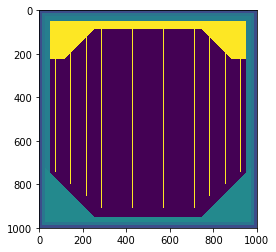

In [5]:
plt.imshow(contactsMask)

## Reduce the shape to 1/2 because of symmetry

In [6]:
nx, ny = contactsMask.shape
contactsMask = contactsMask[:, int(ny / 2):]

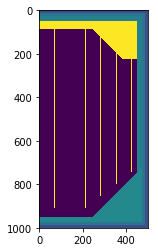

In [7]:
plt.imshow(contactsMask)

## Make illumination

Load the illumination profile. The file can be either a PNG file or a comma sepearted file.

In [8]:
# both csv and png file are supported.
image_file=illumination_filepath
#image_file=join(this_path,"Illumination profile_20180926_random.csv")

In [9]:
def load_illumination(fname):
    _,ext=os.path.splitext(fname)
    ext=ext[1:].lower()
    if (ext=='png'):
        img=imread(fname)
        if img.ndim==3:
            img=img[:,:,0]
    elif (ext=='csv'):
        img=np.loadtxt(fname,delimiter=',')
    return img

In [10]:
img=load_illumination(image_file)

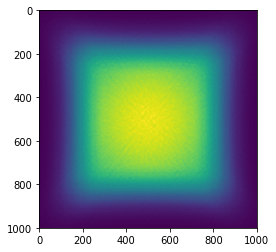

In [11]:
plt.imshow(img)

### Show statistics of the profile

Show histogram of pixel values

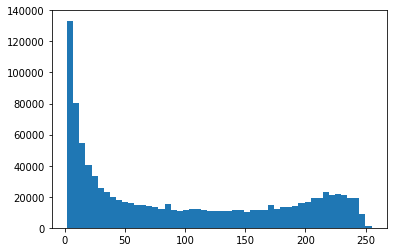

In [12]:
plt.hist(img.ravel(),bins=50)
plt.show()

Total of the pixel value:

In [13]:
value_sum=np.sum(img)
print("The sum of total pixel value: {}".format(value_sum))

The sum of total pixel value: 95974375


In [14]:
pixel_photon_unit=1.1426e11
print("The sum of photon number: {}".format(value_sum*pixel_photon_unit))

The sum of photon number: 1.09660320875e+19


### Reduce the shape to 1/2

In [15]:
illuminationMask=img
illuminationMask=illuminationMask[:, int(img.shape[1] / 2):]

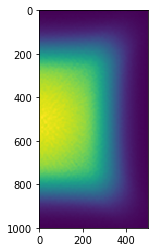

In [16]:
plt.imshow(illuminationMask)

In [17]:
np.max(illuminationMask)

254

In [18]:
illuminationMask.shape

(1000, 500)

## Set solar cell parameters

In [19]:
# Size of the pixels (m)
Lx = 1e-6
Ly = 1e-6

h=2.2e-6

# Bias (V)
vini = 0
vfin = 3.5
step = 0.01

T = 298

## Set the parameter of solar cells

This solar cell solver calculates the saturation current J01 and J02 from detail balanced model (assuming 100% aborptivity). Sheet resistance is assigned by the user.

In [20]:
# the solar cell parameters

gaas_cell = SQCell(1.42, 300, 1)
ingap_cell = SQCell(1.87, 300, 1)
ge_cell = SQCell(0.67, 300, 1)


# assign which solar cell to use. For example, to use top cell, set my_solar_cell like this:
# my_solar_cell=SolarCell([ingap_cell],T=T)
# For full 3J solar cell, the parameter is like this:
# my_solar_cell=SolarCell([ingap_cell,gaas_cell,ge_cell],T=T)
my_solar_cell = MJCell([ingap_cell,gaas_cell,ge_cell])

### Set the light source

In [21]:
my_solar_cell.set_input_spectrum(load_astm("AM1.5g"))

In [22]:
illuminationMask.shape

(1000, 500)

In [23]:
contactsMask.shape

(1000, 500)

### Launch the solver

In [24]:
from spice.parse_spice_input import NodeReducer
from spice.spice_solver import SPICESolver
pw=20

nd = NodeReducer()

sps = SPICESolver(solarcell=my_solar_cell, illumination=illuminationMask,
                  metal_contact=contactsMask, rw=pw, cw=pw, v_start=vini, v_end=vfin,
                  v_steps=step,l_r=Lx,l_c=Ly, h=h, spice_preprocessor=nd)

sps.I = -sps.I * 2

number of data:351


### Voltage map

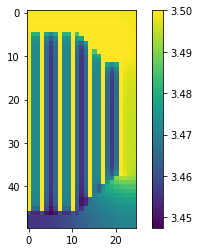

In [25]:
plt.imshow(sps.get_end_voltage_map())
plt.colorbar()

### Downsampled image

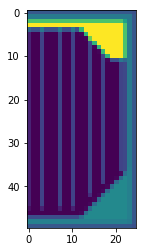

In [26]:
r_image=get_merged_r_image(contactsMask,pw,pw)
plt.imshow(r_image)

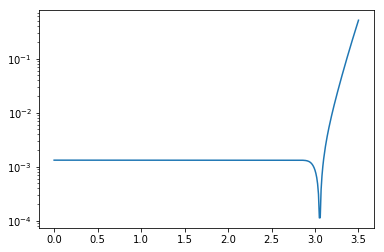

In [27]:
plt.semilogy(sps.V, abs(sps.I))
plt.show()

## Plot in linear scale

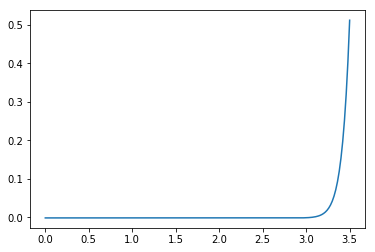

In [28]:
plt.plot(sps.V, sps.I)

Zoom in to negative current

(-0.0014530609104000001, 0)

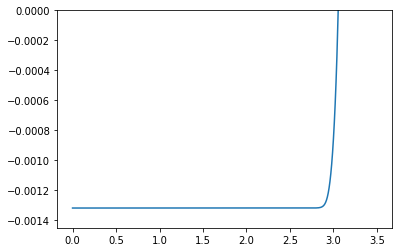

In [29]:
plt.plot(sps.V, sps.I)
plt.ylim([np.min(sps.I)*1.1,0])

## Export the I-V characteristics into a CSV file

The result is written into the file ```iv_result.csv```

In [30]:
output_iv=np.vstack([sps.V,sps.I]).T
np.savetxt(to_data_path('iv_result.csv'),output_iv,delimiter=',')

## Compare simulation with different grid sizes

In [31]:
test_pws=[50,25,10]
file_prefix="3j_pana_"

In [ ]:
%time
result_vi=None
for pw in test_pws:
    nd = NodeReducer()

    sps = SPICESolver(solarcell=my_solar_cell, illumination=illuminationMask,
                  metal_contact=contactsMask, rw=pw, cw=pw, v_start=vini, v_end=vfin,
                  v_steps=step,l_r=Lx,l_c=Ly, h=h, spice_preprocessor=nd)

    # Since we model 1/4 of the device, we multiply the current by 4
    sps.I = -sps.I * 2
    np.save(to_data_path("{}_vmap_{}.npy".format(file_prefix, pw)), sps.get_end_voltage_map())

    if result_vi is None:
        result_vi = np.stack((sps.V, sps.I))
    else:
        result_vi = np.vstack((result_vi, sps.V, sps.I))
        plt.plot(sps.V, sps.I, label="pw: {}".format(pw))

Wall time: 0 ns
number of data:351
number of data:351


In [ ]:
np.savetxt(to_data_path("{}_3j_iv.csv".format(file_prefix)), result_vi.T,
                   delimiter=',')

plt.savefig(to_data_path("{}_1jfig.png".format(file_prefix)))

In [ ]:
iv=np.loadtxt(to_data_path("{}_3j_iv.csv").format(file_prefix),delimiter=',')
for i in range(0,iv.shape[1],2):
    plt.plot(iv[:,i],iv[:,i+1],label="{0}x{0} pixels per node".format(test_pws[i//2]))
    iv_ff=ff(iv[:,i],iv[:,i+1])
    print("fill factor of pw {}: {:.4f}".format(test_pws[i//2],iv_ff))
plt.ylim((np.min(iv[:,1])*1.1,0.001))
plt.xlabel("voltage (V)")
plt.ylabel("current (A)")
plt.legend()
plt.savefig(to_data_path("iv_fig.png"),dpi=300)

In [ ]:
fig,ax=plt.subplots(ncols=len(test_pws)+1,figsize=(8,6),dpi=300)
for i, pw in enumerate(test_pws): 
    r_image=get_merged_r_image(contactsMask,pw,pw)
    ax[i].imshow(r_image)
    ax[i].set_title("{} pixels".format(pw))
r_image=get_merged_r_image(contactsMask,1,1)
ax[-1].imshow(r_image)
ax[-1].set_title("original")
fig.savefig(to_data_path("equiv_r_images.png"))

In [ ]:
fig,ax=plt.subplots(ncols=len(test_pws))
for i, pw in enumerate(test_pws):
    vmap=np.load(to_data_path('{}_vmap_{}.npy').format(file_prefix,pw))
    ax[i].imshow(vmap)